# Precision, recall


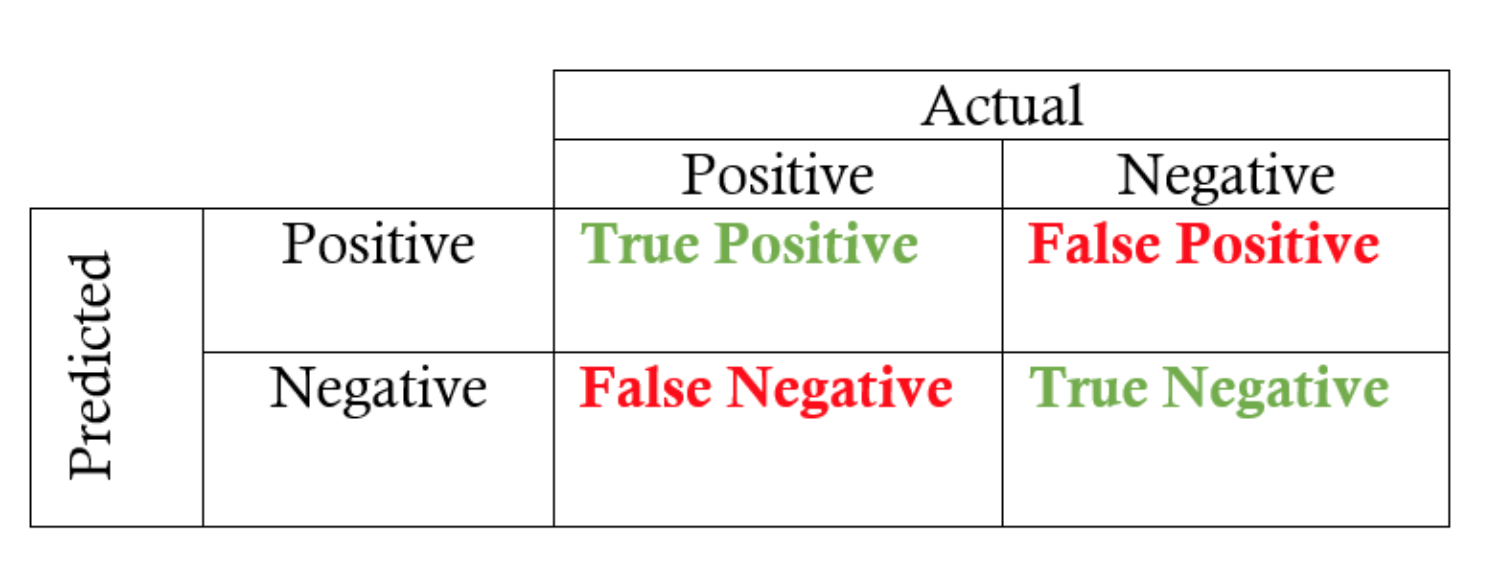


$$ precision = \frac{TP}{TP + FP} $$


$$ recall = \frac{TP}{TP + FN} $$

In [37]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# генерируем данные 
X, y = make_classification(n_samples=100000, n_features=20, 
                           n_classes=2, n_informative=5, 
                           n_redundant=2, random_state=42)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

(100000, 20) (100000,)


In [39]:
# классы сбалансированы
y_train.mean()

0.4998714285714286

In [40]:
# обучим классификатор
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [41]:
y_pred = xgb.predict_proba(X_test)

In [43]:
# вероятность принадлежности к классу 1 - второй столбец - то, что нам нужно
y_pred[:, 1]

array([0.00797739, 0.29839823, 0.0193131 , ..., 0.00694505, 0.98824626,
       0.9875129 ], dtype=float32)

### функция precision_recall_curve возвращает 3 объекта

- массив, содержащий значения precision при всех значениях трешхолда

- массив, содержащий recall при всех значениях трешхолда

- массив, содержащий варианты значения трешхолда (кроме th = 1) (поэтому руками его добавляем) 

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])

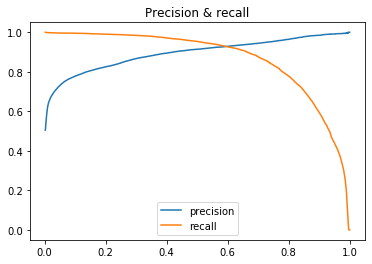

In [6]:
def plot_precision_and_recall(precision, recall, thresholds):
    # The last precision and recall values are 1. and 0. respectively 
    # and do not have a corresponding threshold
    plt.plot(list(thresholds) + [1], precision, label='precision')
    plt.plot(list(thresholds) + [1], recall, label='recall')
    plt.title('Precision & recall')
    plt.legend(loc='lower center')
    plt.show()
    
plot_precision_and_recall(precision, recall, thresholds)

### А что если мы увеличим дисбаланс в тесте (докинем ноликов)?

- Сгенерируем еще объектов для класса y = 0 
- Посмотрим, как изменится график <code>Precision & recall</code> 

In [49]:
# сгенерируем еще только ноликов (n_classes=1)
X_zero, y_zero = make_classification(n_samples=100000, n_features=20, 
                                    n_classes=1, n_informative=5, 
                                    n_redundant=2, random_state=45)

In [50]:
y_zero

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
X_test_extra_zero = np.concatenate([X_zero, X_test])
y_test_extra_zero = np.concatenate([y_zero, y_test])
y_test_extra_zero.mean()

0.11535384615384615

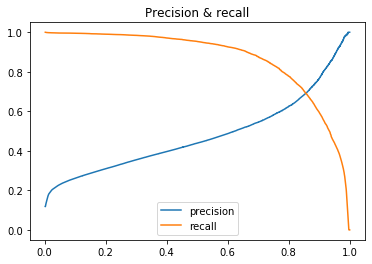

In [52]:
y_pred_extra = xgb.predict_proba(X_test_extra_zero)

precision_extra, recall_extra, thresholds_extra = precision_recall_curve(y_test_extra_zero, y_pred_extra[:, 1])

plot_precision_and_recall(precision_extra, recall_extra, thresholds_extra)

Видим, что графику поплохело:
- precision растет не так резко
- точка пересечения съехала вниз

Еще бы, теперь на тесте классы, мягко говоря, не сбалансированы: единиц только 11,5%

**Вопрос:** что на графике изменилось, а что осталось прежним? 

# Precision@k, recall@k

*произносится как пресижн-эт-кей*

- k - любая перцентиль, например, 10%: precision@10

Нужны тогда, когда бизнесу нужен только ТОП **k** предсказаний. 

Пример: рекламные сегменты. 

В сегментах мы будем отправлять рекламу не всем отскоренным пользователям, а только тем, кто наиболее склонен купить (у кого самый высокий скор)

In [53]:
from sklearn.metrics import precision_score, recall_score


def precision_at_k(y_true, y_pred, th=0.5, k=10):
    
    # value p and index p_index of k-th percentile
    p = np.percentile(y_pred, 100 - k, interpolation='lower')
    p_index = list(y_pred).index(p)
    
    # sort predictions and cut top k 
    y_pred_at_k = np.sort(y_pred, kind='mergesort')[::-1][:p_index]
    # save index to sort labels
    desc_score_ind = np.argsort(y_pred, kind='mergesort')[::-1]
    # sort labels and cut top k
    y_true_at_k = y_true[desc_score_ind][:p_index]
    
    return precision_score(y_true_at_k, (y_pred_at_k > th).astype(int))
    
    
def recall_at_k(y_true, y_pred, th=0.5, k=10):
    
    p = np.percentile(y_pred, 100 - k, interpolation='lower')
    p_index = list(y_pred).index(p)
    
    y_pred_at_k = np.sort(y_pred, kind='mergesort')[::-1][:p_index]
    desc_score_ind = np.argsort(y_pred, kind='mergesort')[::-1]
    y_true_at_k = y_true[desc_score_ind][:p_index]
    
    return recall_score(y_true_at_k, (y_pred_at_k > th).astype(int))

In [54]:
(y_pred[:, 1] > 0.9).astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [55]:
# precision по всем предсказаниям меньше
precision_score(y_test, (y_pred[:, 1] > 0.9).astype(int))

0.9845542806707855

In [56]:
# precision@20 th = 0.9
precision_at_k(y_test, y_pred[:, 1], th=0.9, k=20)

0.990824392998306

In [35]:
recall_at_k(y_test, y_pred[:, 1], th=0.99, k=20)

0.3784014816925488